# Tutorial data

In [ ]:
# import pandas as pd

# data_path = "data/train/day_0_0.001_train.csv"

# df = pd.read_csv(data_path, header=None)
# df.head()

In [ ]:
# example = df.loc[1, 0]
# example

In [ ]:
# features = example.split('\t')
# len(features)
# features

# Read s3 orc data

In [1]:
column_names = []
with open(f'./schema/column_name_mobivista.txt', 'r') as f:
    for line in f:
        column_names.append(line.split(' ')[1].strip())
print(column_names)

['_11001', '_11002', '_11003', '_11004', '_11007', '_11008', '_11021', '_11022', '_11023', '_11024', '_11041', '_11042', '_11043', '_11044', '_11045', '_11046', '_11061', '_11062', '_11063', '_11064', '_11065', '_11066', '_11081', '_11082', '_11083', '_11084', '_11085', '_11086', '_11601', '_11602', '_11603', '_12001', '_12002', '_12003', '_12004', '_12005', '_12006', '_20001', '_20002', '_20003', '_20101', '_20102', '_20201', '_20202', '_20203', '_20204', '_20205', '_20206', '_20207', '_20208', '_20209', '_20210', '_30001', '_30002', '_30003', '_30004', '_30005', '_30006', '_30201', '_30202', '_30203', '_30204', '_30205', '_30206', '_30207', '_40001', '_40002', '_40003', '_40004', '_40005', '_40201', '_40202', '_40203', '_40204', '_40205', '_40206', '_40207', '_40208', '_40209', '_40210', '_40211', '_40212', '_40213', '_40214', '_40215', '_40231', '_40301', '_40302', '_40303', '_40304', '_40305', '_40306', '_40307', '_40321', '_40322', '_40323', '_40324', '_50801', '_50802', '_50805',

In [2]:
import metaspore as ms

# train_dataset_path = ROOT_DIR + '/data/train/day_0_0.001_train.csv'

file_base_path = 's3://mv-mtg-di-for-poc-datalab/2024/06/14/00/'
num_files = 10
file_names = [f'part-{str(i).zfill(5)}-1e73cc51-9b17-4439-9d71-7d505df2cae3-c000.snappy.orc' for i in range(num_files)]
train_dataset_path = [file_base_path + file_name for file_name in file_names]

# # train_dataset_path = 's3://mv-mtg-di-for-poc-datalab/2024/06/14/00/part-00000-1e73cc51-9b17-4439-9d71-7d505df2cae3-c000.snappy.orc'
# train_dataset_path = 's3://mv-mtg-di-for-poc-datalab/2024/06/14/00/'
# train_dataset_path = [
#     's3://mv-mtg-di-for-poc-datalab/2024/06/14/00/',
#     's3://mv-mtg-di-for-poc-datalab/2024/06/14/01/',
#     's3://mv-mtg-di-for-poc-datalab/2024/06/14/02/',
# ]


spark_confs = {
    'spark.eventLog.enabled':'true',
    'spark.executor.memory': '10g',
    'spark.driver.memory': '10g',
    "spark.driver.maxResultSize": "10g",
    "spark.sql.files.ignoreCorruptFiles": "true"
}

spark_session = ms.spark.get_session(local=True,
                                     batch_size=100,
                                     worker_count=2,
                                     server_count=2,
                                     log_level='WARN',
                                     spark_confs=spark_confs)


# train_dataset = ms.input.read_s3_csv(spark_session, 
#                                     train_dataset_path, 
#                                     format='orc',
#                                     shuffle=False,
#                                     delimiter='\t', 
#                                     multivalue_delimiter="\001", 
#                                     column_names=column_names,
#                                     multivalue_column_names=column_names[:-1])

# # train_dataset.printSchema()
# train_dataset.count()

/usr/local/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-22 09:16:48,328 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
from tqdm import tqdm
import pandas as pd
pd.set_option("display.max_columns", None)

columns = column_names[:-1]
feature_hash = {}
feature_value = {}

num_files_per_chunk = 10
num_chunks = (num_files + num_files_per_chunk - 1) // num_files_per_chunk

num_rows = 0

for i in tqdm(range(num_chunks), total=num_chunks):
    chunk_path = train_dataset_path[i*num_files_per_chunk:(i+1)*num_files_per_chunk]

    # Read the chunk
    train_dataset = ms.input.read_s3_csv(spark_session, 
                                     chunk_path, 
                                     format='orc',
                                     shuffle=False,
                                     delimiter='\t', 
                                     multivalue_delimiter="\001", 
                                     column_names=column_names,
                                     multivalue_column_names=column_names[:-1])
    
    # Convert the chunk to a Pandas DataFrame
    df = train_dataset.toPandas()
    # df.head()
    num_rows += df.shape[0]

    # num_positive = df[df['label']=='1'].shape[0]
    # num_negative = df[df['label']=='0'].shape[0]
    # print(f"num_positive: {num_positive}, num_negative: {num_negative}, ratio: {num_positive/num_negative*100}")

    for i, row in df.iterrows(): # tqdm(df.iterrows(), total=df.shape[0]):
        for column in columns[:-1]:
            if column in feature_value:
                feature_value[column].append(row[column].shape[0])
            else:
                feature_value[column] = [row[column].shape[0]]
            
            for item in row[column]:
                if '\003' in item:
                    hash, weight = item.split('\003')
                else:
                    hash, weight = '', 0
                if column in feature_hash:
                    feature_hash[column].add(hash)
                else:
                    feature_hash[column] = set(hash)

print(f"Number of files: {num_files}, number of rows: {num_rows}")

  0%|          | 0/1 [00:00<?, ?it/s]

ignore shuffle


2024-07-22 09:16:56,447 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
100%|██████████| 1/1 [04:31<00:00, 271.12s/it]                                  

Number of files: 10, number of rows: 124491


In [4]:
df_feature = pd.DataFrame(feature_value)
df_feature.describe()

,_11001,_11002,_11003,_11004,_11007,_11008,_11021,_11022,_11023,_11024,_11041,_11042,_11043,_11044,_11045,_11046,_11061,_11062,_11063,_11064,_11065,_11066,_11081,_11082,_11083,_11084,_11085,_11086,_11601,_11602,_11603,_12001,_12002,_12003,_12004,_12005,_12006,_20001,_20002,_20003,_20101,_20102,_20201,_20202,_20203,_20204,_20205,_20206,_20207,_20208,_20209,_20210,_30001,_30002,_30003,_30004,_30005,_30006,_30201,_30202,_30203,_30204,_30205,_30206,_30207,_40001,_40002,_40003,_40004,_40005,_40201,_40202,_40203,_40204,_40205,_40206,_40207,_40208,_40209,_40210,_40211,_40212,_40213,_40214,_40215,_40231,_40301,_40302,_40303,_40304,_40305,_40306,_40307,_40321,_40322,_40323,_40324,_50801,_50802,_50805,_50806,_50807,_50810,_51001,_51002,_51003,_51004,_51005,_51006,_51011,_51012,_51013,_51014,_51021,_51022,_51023,_51024,_51025,_51026,_51031,_51032,_51033,_51034,_51035,_51036,_51041,_51042,_51043,_51044,_51045,_51046,_52001,_52002,_52003,_52004,_52005,_61101,_61102,_61103,_70001,_70002,_70003,_70004,_70005,_70006,_70007,_70008,_70009,_70010,_70011,_70031,_70032,_70033,_70034,_70035,_70036,_70037,_70038,_70039,_70040,_70041,_70301,_70302,_70303,_70304,_70305,_70306,_70601,_70602,_70603,_70604,_70605,_70606,_70901,_70902,_70903,_70904,_70905,_70906,_72401,_72402,_80001,_80002,_80003,_80004,_80005,_80006,_80007,_80008,_80009,_80010,_80011,_80012,_80013,_80014,_80015,_80016,_80017,_80018,_80019,_80020,_80021,_80022,_80023,_80024,_80025,_80026,_80027,_80028,_80029,_80030,_80031,_80032,_80033,_80034,_80035,_80036,_80037,_80038,_80039,_80040,_80041,_80042,_80043,_80044,_80045,_80046,_80047,_80048,_80049,_80050,_80051,_80052,_80053,_80054,_80055,_80056,_80057,_80058,_80059,_80060,_80061,_80062,_80063,_80064,_80065,_80066,_80067,_80068,_80069,_80070,_80071,_80072,_80073,_80074,_80075,_80076,_80077,_80078,_80079,_80080,_80081,_80082,_80083,_80084,_80085,_80086,_80087,_80088,_80089,_80090,_80091,_80092,_80093,_80094,_80095,_80096,_80097,_80098,_80099,_80100,_80101,_80102,_80103,_80104,_80105,_80106,_80107,_80108,_80109,_80110,_80111,_80112,_80113,_80114,_80115,_80125,_80126,_80127,_80128,_80129,_80130,_80131,_80132,_80133,_80134,_80135,_80136,_80137,_80138,_80139,_80140,_80141,_80142,_80143,_80144,_80145,_80146,_80147,_80148,_80149,_80150
count,124491.000000,124491.000000,124491.0,124491.0,124491.000000,124491.0,124491.000000,124491.000000,124491.0,124491.0,124491.000000,124491.000000,124491.000000,124491.0,124491.0,124491.0,124491.000000,124491.000000,124491.000000,124491.0,124491.0,124491.0,124491.000000,124491.000000,124491.000000,124491.0,124491.0,124491.0,124491.000000,124491.000000,124491.000000,124491.000000,124491.000000,124491.000000,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.000000,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.000000,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,124491.0,1

In [5]:
feature_hash_count = dict([(k, [len(v)]) for k, v in feature_hash.items()])
df_hash = pd.DataFrame(feature_hash_count)
df_hash

,_11001,_11002,_11003,_11004,_11007,_11008,_11021,_11022,_11023,_11024,_11041,_11042,_11043,_11044,_11045,_11046,_11061,_11062,_11063,_11064,_11065,_11066,_11081,_11082,_11083,_11084,_11085,_11086,_11601,_11602,_11603,_12001,_12002,_12003,_12004,_12005,_12006,_20001,_20002,_20003,_20101,_20102,_20201,_20202,_20203,_20204,_20205,_20206,_20207,_20208,_20209,_20210,_30001,_30002,_30003,_30004,_30005,_30006,_30201,_30202,_30203,_30204,_30205,_30206,_30207,_40001,_40002,_40003,_40004,_40005,_40201,_40202,_40203,_40204,_40205,_40206,_40207,_40208,_40209,_40210,_40211,_40212,_40213,_40214,_40215,_40231,_40301,_40302,_40303,_40304,_40305,_40306,_40307,_40321,_40322,_40323,_40324,_50801,_50802,_50805,_50806,_50807,_50810,_51001,_51002,_51003,_51004,_51005,_51006,_51011,_51012,_51013,_51014,_51021,_51022,_51023,_51024,_51025,_51026,_51031,_51032,_51033,_51034,_51035,_51036,_51041,_51042,_51043,_51044,_51045,_51046,_52001,_52002,_52003,_52004,_52005,_61101,_61102,_61103,_70001,_70002,_70003,_70004,_70005,_70006,_70007,_70008,_70009,_70010,_70011,_70031,_70032,_70033,_70034,_70035,_70036,_70037,_70038,_70039,_70040,_70041,_70301,_70302,_70303,_70304,_70305,_70306,_70601,_70602,_70603,_70604,_70605,_70606,_70901,_70902,_70903,_70904,_70905,_70906,_72401,_72402,_80001,_80002,_80003,_80004,_80005,_80006,_80007,_80008,_80009,_80010,_80011,_80012,_80013,_80014,_80015,_80016,_80017,_80018,_80019,_80020,_80021,_80022,_80023,_80024,_80025,_80026,_80027,_80028,_80029,_80030,_80031,_80032,_80033,_80034,_80035,_80036,_80037,_80038,_80039,_80040,_80041,_80042,_80043,_80044,_80045,_80046,_80047,_80048,_80049,_80050,_80051,_80052,_80053,_80054,_80055,_80056,_80057,_80058,_80059,_80060,_80061,_80062,_80063,_80064,_80065,_80066,_80067,_80068,_80069,_80070,_80071,_80072,_80073,_80074,_80075,_80076,_80077,_80078,_80079,_80080,_80081,_80082,_80083,_80084,_80085,_80086,_80087,_80088,_80089,_80090,_80091,_80092,_80093,_80094,_80095,_80096,_80097,_80098,_80099,_80100,_80101,_80102,_80103,_80104,_80105,_80106,_80107,_80108,_80109,_80110,_80111,_80112,_80113,_80114,_80115,_80125,_80126,_80127,_80128,_80129,_80130,_80131,_80132,_80133,_80134,_80135,_80136,_80137,_80138,_80139,_80140,_80141,_80142,_80143,_80144,_80145,_80146,_80147,_80148,_80149,_80150
0,8761,8527,10,12,9154,10,7344,8259,2,2,8855,10484,11521,11,9,10,16029,25598,25847,2,11,10,43178,58036,73739,11,10,10,95553,57019,29786,65942,67758,68966,10,8,9,218,13865,99,17,15,471,4072,144,13,19,15,81,16,84,16,10,16,11740,21352,19943,1809,11349,4440,4848,1895,18,62,138,679,5440,8263,23,8,14,3068,12,5726,10,22,20,13,27,31,6562,13964,3491,2060,1621,15,5028,1986,1880,777,16,61,130,48,17,25,2454,9,9,8,9,11,10,1707847,2,1505328,10,1831405,11,493610,2,802038,2,207442,2,422095,2,637901,2,92121,2,212385,2,212854,2,625308,2,1017675,2,1410049,2,1347016,2,1186282,2,1075488,2,2,2,74315,84093,9497,25305,30778,31007,7881,20007,84262,87316,84443,78492,87663,13931,32517,38248,33770,11779,25963,90573,90584,90734,18946,30678,99,434,838,9,37506,51095,366,1638,2875,2,43480,57305,677,2858,4695,2,2,2,5989,13021,108,208,4971,6396,2208,5720,33,35,7264,7544,109,106,101,89,84,83,79,109,96,93,81,76,75,68,72,63,58,53,56,55,53,110,101,57,39,7000,5818,109,101,5685,3478,1201,5779,33,33,3899,7232,107,100,81,81,80,68,68,108,90,69,62,60,57,53,32,27,26,28,28,32,24,103,119,76,39,20208,109,9793,2100,11272,46,41,44,39,42,40,40,16421,109,13496,178,10293,61,76,76,79,66,72,58,16,16,16,15,15,16,18,11,16,10,16,17,15,9,18,15,17,16,17,17,15,15,17,17,16,9,981789,74727,71797,351546,4124,62633,23227,23555,247117,3650,667195,91323,48662,81298,382995,182981,42645


In [6]:
hashes = set()

for k, v in feature_hash.items():
    hashes |= v
print(f"Number of total hashes: {len(hashes)}")

Number of total hashes: 9684510


In [7]:
total_hash = df_hash.sum(axis=1).values[0]
print(f"Number of total hashes: {total_hash}")

Number of total hashes: 20558246


# Use pyspark to analyze

In [ ]:
columns = []
with open(f'./schema/column_name_mobivista.txt', 'r') as f:
    for line in f:
        columns.append(line.split(' ')[1].strip())
print(columns)

In [ ]:
import metaspore as ms
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, explode, sum as spark_sum, countDistinct
from pyspark.sql.types import ArrayType, IntegerType, StructType, StructField, StringType

# Read column names from file
columns = []
with open('./schema/column_name_mobivista.txt', 'r') as f:
    for line in f:
        columns.append(line.split(' ')[1].strip())
print(columns)

# Define Spark configuration and session
file_base_path = 's3://mv-mtg-di-for-poc-datalab/2024/06/14/00/'
num_files = 1
file_names = [f'part-{str(i).zfill(5)}-1e73cc51-9b17-4439-9d71-7d505df2cae3-c000.snappy.orc' for i in range(num_files)]
train_dataset_path = [file_base_path + file_name for file_name in file_names]

spark_confs = {
    'spark.eventLog.enabled': 'true',
    'spark.executor.memory': '10g',
    'spark.driver.memory': '10g',
    "spark.driver.maxResultSize": "10g",
    "spark.sql.files.ignoreCorruptFiles": "true"
}

spark_session = ms.spark.get_session(local=True,
                                     batch_size=100,
                                     worker_count=3,
                                     server_count=3,
                                     log_level='WARN',
                                     spark_confs=spark_confs)

# Load the dataset
train_dataset = ms.input.read_s3_csv(spark_session, 
                                     train_dataset_path, 
                                     format='orc',
                                     shuffle=False,
                                     delimiter='\t', 
                                     multivalue_delimiter="\001", 
                                     column_names=columns,
                                     multivalue_column_names=columns[:-1])

print(f"Number of orcs: {num_files}, total number of rows: {train_dataset.count()}")

# Define UDF to process rows
def process_row(column_values):
    feature_hashes = set()
    for value in column_values:
        if '\003' in value:
            hash_val, weight = value.split('\003')
        else:
            hash_val, weight = '', 0
        feature_hashes.add(hash_val)

    feature_values = len(column_values)
    return (feature_values, list(feature_hashes))

# Define schema for UDF output
schema = StructType([
    StructField("feature_values", IntegerType(), True),
    StructField("hashes", ArrayType(StringType()), True)
])

# Register the UDF
process_row_udf = udf(process_row, schema)

# Apply UDF on each column and process the dataset
for column in columns[:-1]:
    train_dataset = train_dataset.withColumn(f'{column}_processed', process_row_udf(col(column)))

train_dataset.show()


In [ ]:
# Extract the processed columns
result_columns = [f'{column}_processed' for column in columns[:-1]]
processed_df = train_dataset.select(*result_columns)
processed_df.show()

In [ ]:
# Select the desired row and column
row_value = train_dataset.select('_11002_processed').collect()[4][0]

# Print the value
print(row_value)

In [ ]:
# 1. Obtain the percentiles of feature_values using approxQuantile
from tqdm import tqdm
percentiles = [0.25, 0.5, 0.75, 1.0]

for col_name in tqdm(processed_df.columns, total=len(processed_df.columns)):
    feature_values_df = processed_df.select(col(f"{col_name}.feature_values").cast("double").alias("feature_values"))
    
    # Print schema to verify cast
    # feature_values_df.printSchema()
    
    # Show data to verify cast
    # feature_values_df.show()
    
    # Verify the data type of the column
    # data_type = feature_values_df.schema["feature_values"].dataType
    # print(f"Data type of feature_values in {col_name}: {data_type}")
    
    # # Check for null values or any anomalies in the column
    # null_count = feature_values_df.filter(col("feature_values").isNull()).count()
    # print(f"Number of null values in feature_values of {col_name}: {null_count}")
    
    # Obtain approximate percentiles
    try:
        percentile_values = feature_values_df.approxQuantile("feature_values", percentiles, 0.01)
        # print(f"Percentiles for {col_name}: {percentile_values}")
    except Exception as e:
        print(f"Error occurred while calculating percentiles for {col_name}: {e}")

# 2. Obtain the total number of different hash values for each column and across all columns
distinct_hash_counts = {}
all_hashes_df = []

print(f"Starting counting hashes")
for col_name in tqdm(processed_df.columns, total=len(processed_df.columns)):
    hashes_df = processed_df.select(explode(col(f"{col_name}.hashes")).alias("hashes"))
    distinct_count = hashes_df.select(countDistinct("hashes")).first()[0]
    distinct_hash_counts[col_name] = distinct_count
    all_hashes_df.append(hashes_df)

union_hashes_df = all_hashes_df[0]
for df in all_hashes_df[1:]:
    union_hashes_df = union_hashes_df.union(df)

total_distinct_hashes = union_hashes_df.select(countDistinct("hashes")).first()[0]

print(f"Distinct hash counts per column: {distinct_hash_counts}")
print(f"Total distinct hashes across all columns: {total_distinct_hashes}")

# Stop the Spark session
# spark.stop()

# To do data approximation

{2148: 398142946, 35787: 2788499930}


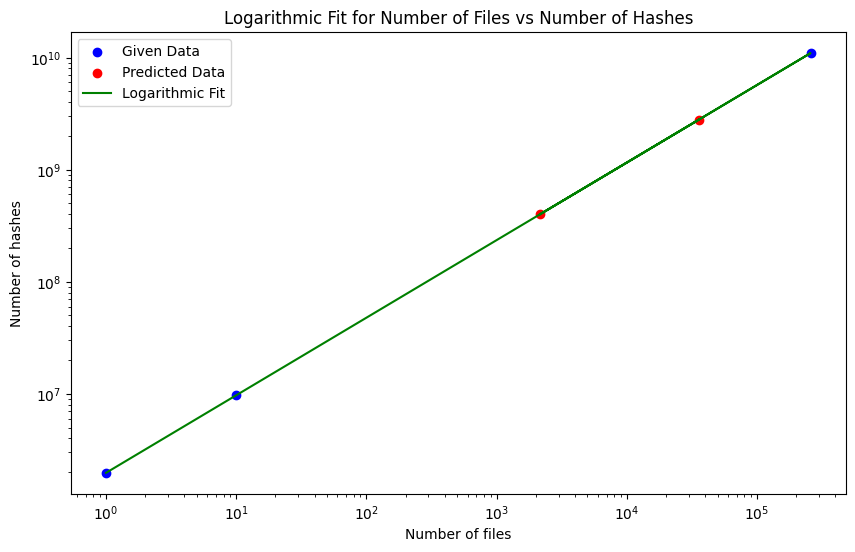

In [22]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Given data
number_of_files = np.array([1, 10, 258416]).reshape(-1, 1)
number_of_hashes = np.array([1959220, 9758165, 10937500000])

# Logarithm fit for the given data
x_log = np.log10(number_of_files)
y_log = np.log10(number_of_hashes)

# Fit the linear model on the log-transformed data
log_model = LinearRegression()
log_model.fit(x_log, y_log)

# Predict missing values on the log scale
missing_files = np.array([2148, 35787]).reshape(-1, 1)
missing_files_log = np.log10(missing_files)
predicted_hashes_log = log_model.predict(missing_files_log)
predicted_hashes = 10 ** predicted_hashes_log  # convert back to the original scale

# Print predicted values
predicted_hashes_dict = {n_files: int(n_hashes) for n_files, n_hashes in zip(missing_files.flatten(), predicted_hashes)}
print(predicted_hashes_dict)

# Plotting the fit and the predictions
plt.figure(figsize=(10, 6))
plt.scatter(number_of_files, number_of_hashes, color='blue', label='Given Data')
plt.scatter(missing_files, predicted_hashes, color='red', label='Predicted Data')
plt.plot(np.concatenate([number_of_files, missing_files]), 
         10 ** log_model.predict(np.log10(np.concatenate([number_of_files, missing_files]))), 
         color='green', label='Logarithmic Fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of files')
plt.ylabel('Number of hashes')
plt.legend()
plt.title('Logarithmic Fit for Number of Files vs Number of Hashes')
plt.show()


In [24]:
2788499930*16*4/10**9

178.46399552